# Plot feature permutation importance (FPI) results

This notebook will visualize/consolidate the FPI results of the machine learning runs (organized in different branches) in this repositiory.

The input variable (i.e. feature) names from RiverAtlas in the format of <nnn>_<uu>_<sss> (name, unit, scale: local reach or upstream catchment) are full defined in the [RiverAtlas data catalog](https://data.hydrosheds.org/file/technical-documentation/RiverATLAS_Catalog_v10.pdf).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#from matplotlib.collections import PatchCollection
#from matplotlib.patches import Rectangle
# Define the repository url to work with and prefix for where it will be copied.
repo_prefix = '~/tmp/'
repo_name = 'sl-archive-whondrs'
repo_url = 'https://github.com/parallelworks/'+repo_name

# Number of independent SuperLearners
# (assumed to be the same for all branches in repo)
num_sl = 10

# Function to prefilter all _-1hot-_ variables when loading
def load_and_filter_fpi(filename):
    # Read file
    raw_csv = pd.read_csv(filename, index_col=0)
    
    # Flatten _-1hot-_ features to a single feature.
    # The .drop_duplicates() operation takes advantage
    # of the fact that the FPI results are always the same
    # for all entries in a 1hot feature.
    # (except for the feature name)
    # DO NOT apply over whole dataframe because otherwise will drop
    # other correlated groupings of inputs, i.e. like this:
    #-------------------------------------------------------
    #raw_csv.drop_duplicates(inplace=True)
    #-------------------------------------------------------
    # Instead, first get a DF for only onehot variables,
    # drop those duplicates in place,
    onehot_filtered = raw_csv.filter(regex='_-1hot-_', axis=0).drop_duplicates()
    # Then get the not-1hot features "nothot",
    nothot = raw_csv.filter(regex='^((?!_-1hot-_).)*$', axis=0)
    # And finally concatenate the two together
    output = pd.concat([onehot_filtered,nothot],axis=0)
    
    # Remove the _-1hot-_ categories from the feature names,
    # but keep the feature name prefix. Note expand split strings
    # to columns so I can reference only the first column with [0].
    feature_names = pd.Series(output.index).str.split('_-1hot-_',expand=True)[0]
    
    # Reset the index based on the renamed values
    output.index=feature_names
    
    # Done
    return output

## Grab data

Since the ML runs are on different branches, we need to jump from branch-to-branch and gather and plot data along the way.

On first branch; clone, checkout, and build feature integer ID lookup table...
fatal: destination path 'sl-archive-whondrs' already exists and is not an empty directory.
Checking out files: 100% (316/316), done.
Switched to branch 'Summer-2019-log10-r07'
Significant features for the ML model on this branch:
1 --- Total_Photorophs_cells_per_gram
Checking out files: 100% (240/240), done.
Switched to branch 'Summer-2019-log10-r08'
Significant features for the ML model on this branch:
Checking out files: 100% (302/302), done.
Switched to branch 'Summer-2019-log10-r09'
Significant features for the ML model on this branch:
Switched to branch 'S19S-SSS-log10-r02'
Significant features for the ML model on this branch:
1 --- Depositional_Type
2 --- General_Vegetation
3 --- MiniDot_Sediment
4 --- Hydrogeomorphology
5 --- River_Gradient
6 --- Intermittent_or_Perennial
7 --- gla_pc_cse
8 --- prm_pc_cse
9 --- prm_pc_use
10 --- RA_lm
11 --- my_lm
12 --- kar_pc_cse
13 --- kar_pc_use
14 --- soc_th_cav


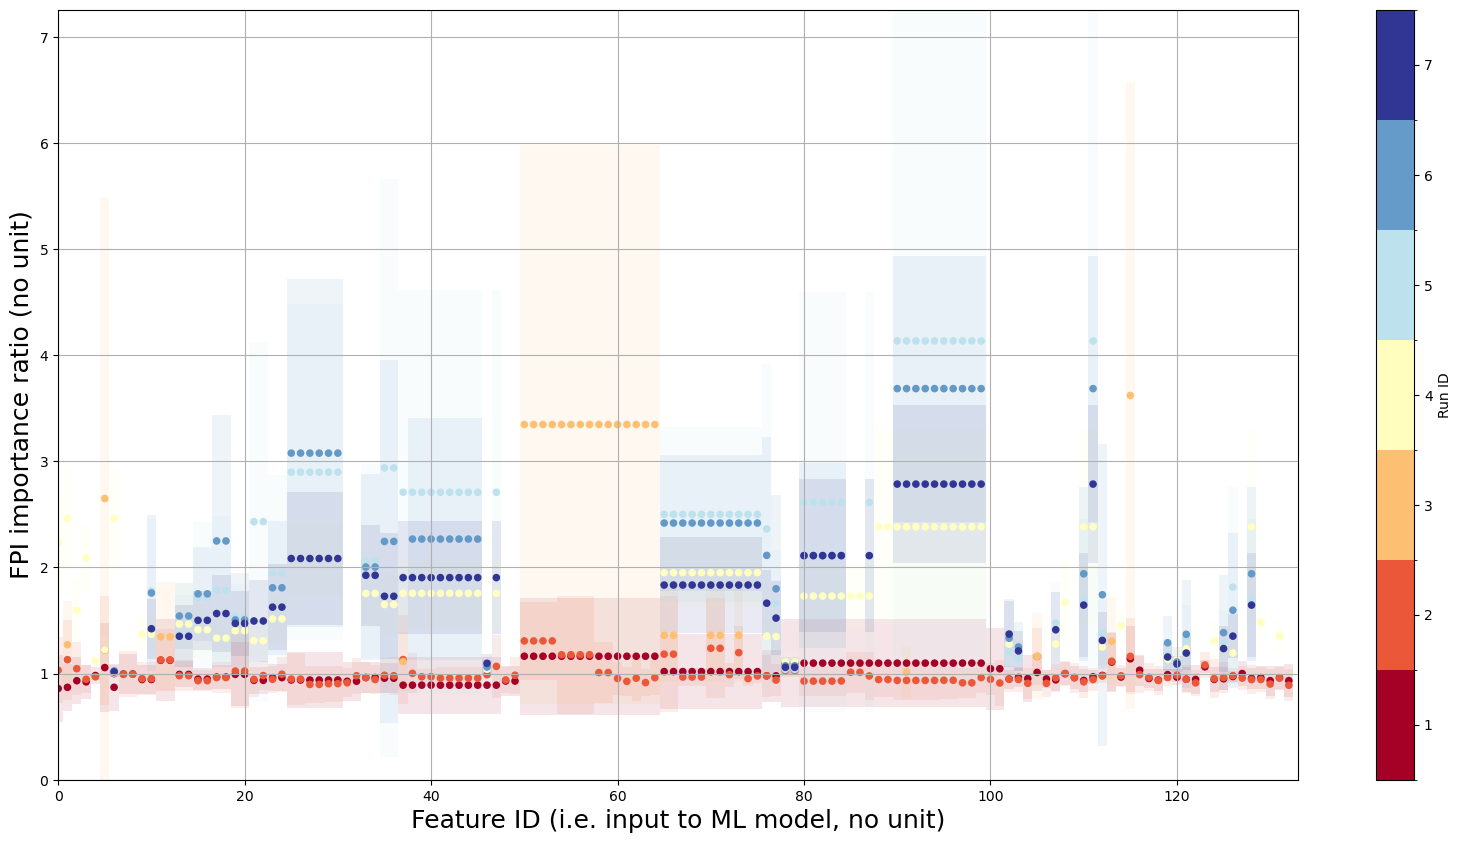

In [2]:
# Make a list of which branches to operate on.
# ASSUME that the first branch will have the most
# complete list of features (i.e. inputs) to the ML
# models. This first list of features will be
# used to create a look-up table for feature-to-feature
# comparisons/visulizations later.

# S19S data only: Summer-2019-log10-rXX branches
# r01 - all features (163), FPI cutoff = 0.5
# r02 - subset of features (134 - based on r01), FPI cutoff = 0.5
# r03 - subset of features (134 - based on r01), FPI cutoff = 0.7
# r04 - all features (163), FPI cutoff = 0.7
# r05 - subset of features (35 - based on r04), FPI cutoff = 0.7
# r05b - repeat r05
# r06 - repeat r04 but with FPI cutoff = 0.9
# r07 - repeat r04 but without duplicate points, FPI cutoff = 0.7
#       All previous branches in Summer-2019-log10-r* series suffer
#       from duplicate data points in training set due to duplicate NPOC data.
#       This issue has been resolved moving forward.
# r08 - repeat r07 but with FPI cutoff = 0.9
# r09 - FPI cutoff = 0.7, using merged list of the top 20 features of r07 
#       and r08 -> 29 total features (of which two are 1hot -> the one hot
#       "channels" count as extra features, so the "true" feature count is
#       33 total, including the 1hot channels.

# Merged S19S-SSS data: S19S-SSS-log10-rXX branches
# S19S-SSS-log10-r01 - merged S19S-SSS data with no FTICR, all 145 input vars, FPI cutoff = 0.7
#                      r01 is likely not useful for FPI because
#                      half the dataset has fill values for isotopes, sediment, NPOC,
#                      cytometry, and %C/%N b/c those features are not available in SSS
#                     (I made a mistake and forgot that it's not just FTICR that is missing
#                     in SSS.)
# S19S-SSS-log10-r02 - merged S19S-SSS data with no FTICR, isotopes, sediment, NPOC, cytometry, %C/%N, all 130 input vars, FPI cutoff = 0.7
# S19S-SSS-log10-r02b - repeatability test for r02.

#list_branches = ['Summer-2019-log10-r04', 'Summer-2019-log10-r03','Summer-2019-log10-r05','Summer-2019-log10-r05b']
list_branches = [
    'Summer-2019-log10-r07',
    'Summer-2019-log10-r08',
    'Summer-2019-log10-r09',
    'S19S-SSS-log10-r02',
    'S19S-SSS-log10-extrap-r01',
    'S19S-SSS-log10-extrap-r02',
    'S19S-SSS-nolog-extrap-r01',
]
fpi_max = 0.0

# Initialize empty dataframes
# for model scores and histograms
model_scores = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain'])
train_hist_df_list = []       #pd.DataFrame(columns=list_branches)
predict_avg_hist_df_list = [] #pd.DataFrame(columns=list_branches)
predict_all_hist_df_list = []

# Initialize a plot
fig, ax = plt.subplots(1,1,figsize=(20,10)) #,facecolor='black')
#ax.set_facecolor('black')

# Set up colormap
cmap = mpl.cm.RdYlBu
#cmap = mpl.cm.viridis
ticks = list(range(0,len(list_branches)+1))
bounds = np.add(ticks,0.5)
#norm = mpl.colors.Normalize(vmin=1, vmax=len(list_branches))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N) #, extend='Both')

# Set up colorbar
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Run ID', ticks=ticks)

# Keep track of the number of features discovered as branches are loaded
num_features = 0

# Keep track of centers of each FPI rectangle
scatter_id = []
scatter_mean = []
scatter_size = []
scatter_color = []
branch_color = []

for ll,branch in enumerate(list_branches):
    
    # Check for first branch
    if ll == 0:
        print("On first branch; clone, checkout, and build feature integer ID lookup table...")
        ! mkdir -p {repo_prefix}
        ! cd {repo_prefix}; git clone {repo_url}
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
        # Get a list of all the files on this branch. This is not necessary
        # for the analysis in this notebook but helpful for cross checking
        # the data and generating DOI descriptors.
        #! cd {repo_prefix}/{repo_name}; find . > ~/{branch}.list
        
        #===========================================
        # Load data for look up table only
        fpi_avg = load_and_filter_fpi(repo_prefix+repo_name+'/output_data/fpi_avg.csv')
        
        # Make the look up table; need to invert
        # the keys (integers) with the values (feature names)
        # so that feature names can be converted to ints
        # later.
        feature_id_name_dict = dict((v,k) for k,v in pd.DataFrame(data=fpi_avg.index).to_dict()[0].items())
        #==========================================
        
        # Count the number of features
        num_features = len(feature_id_name_dict)
        
        # Unload the data b/c later we will want to use the index
        del fpi_avg
    else:
        # Set up is complete with first branch, just change to other branches
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
        # Get a list of all the files on this branch
        #! cd {repo_prefix}/{repo_name}; find . > ~/{branch}.list
    
    # Load data and replace feature names with IDs in dict
    # In the process, get a list of features available in
    # just this branch.
    #---#fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=0)
    fpi_avg = load_and_filter_fpi(repo_prefix+repo_name+'/output_data/fpi_avg.csv')
    branch_feature_names = list(fpi_avg.index)
    
    # Check all features in this branch are in the feature ID dict
    # and if it is not, add it.
    for feature in branch_feature_names:
        if feature not in feature_id_name_dict:
            num_features = num_features + 1
            feature_id_name_dict[feature] = num_features
            print('Added feature: '+feature+' with feature ID: '+str(num_features))
        
    # Update the data file so it can be indexed by feature ID
    # instead of feature name.
    fpi_avg.rename(index=feature_id_name_dict, inplace=True)
    
    fpi_std = load_and_filter_fpi(repo_prefix+repo_name+'/output_data/fpi_std.csv')
    fpi_std.rename(index=feature_id_name_dict, inplace=True)
    
    # Get summary statistics over each FPI (random shuffle
    # of grouped features) iteration
    mean = fpi_avg.mean(axis=1)
    upper = fpi_avg.mean(axis=1)+fpi_avg.std(axis=1)
    lower = fpi_avg.mean(axis=1)-fpi_avg.std(axis=1)
    uncert = fpi_std.max(axis=1)
    
    # If the max value is bigger than the current value,
    # update it.
    if upper.max() > fpi_max:
        fpi_max = upper.max()
        
    # Start printing out good features:
    # Printing disabled since adding tablulation below
    print('Significant features for the ML model on this branch:')
    ff = 1
    
    # Set the branch color
    run_id = len(model_scores.index)
    branch_color.append(run_id+1)
    
    # Plot a box for each feature. We work feature by feature
    # because not all features will be available and not all
    # are chopped out from the edges either; sometimes features
    # will be chopped out from the middle so we don't want to
    # plot continuous lines.
    for feature in branch_feature_names:
        
        # Get feature ID from the dict
        f_id = feature_id_name_dict[feature]
        
        # Get the center of the box
        f_mean = mean[f_id]
        
        # Get the upper and lower bounds of the box
        f_upper = upper[f_id] 
        f_lower = lower[f_id]
        f_uncert = uncert[f_id]
        
        # Get information about means for plotting later
        scatter_id.append(f_id)
        scatter_mean.append(f_mean)
        scatter_size.append(20)
        scatter_color.append(run_id+1)
        
        # Set size of rectangle
        left, bottom, width, height = (f_id - 0.5, f_lower, 1.0, f_upper-f_lower)
        
        # Plot rectangle. Note, need to scale color to match
        # colorbar range [0,1], so:
        # run_id = 1 -> 0
        # run_id = list_branches -> 1
        # The extra +1 on run_id accounts for converting it
        # from count starting at 0 (for Pandas index) to
        # count starting at 1.
        rect = plt.Rectangle((left, bottom), width, height,
            facecolor=cmap(((run_id+1) - 1)/(len(list_branches) - 1)), alpha=0.1)
    
        # Add collection to axes
        ax.add_patch(rect)
        
        # Print out feature name if it is a significant contribution
        # (Here, assume that "significant" means the lowest bound on
        # the FPI improvement ratio is above 1.0)
        if f_lower > 1.0:
            print(str(ff)+" --- "+feature)
            ff = ff + 1
            
    # Clear loaded data
    del fpi_std
    del fpi_avg
    
    # Load model scores
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    input_data = pd.read_csv(repo_prefix+repo_name+'/input_data/WHONDRS_Data.csv')
    
    model_scores.loc[run_id] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
    ]
    
    # Grab histograms of the distribution of the target to
    # assess bias in the ML models
    #train_all = pd.read_csv(repo_prefix+repo_name+'/input_data/WHONDRS_Data.csv')
    #train_hist[branch] = train_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    train_hist_df_list.append(pd.read_csv(repo_prefix+repo_name+'/input_data/WHONDRS_Data.csv')) 
    
    # Some predictions are not included in unfiltered_predict_output_avg.csv
    # due to the built-in filters for oxygen and missing values in the PCA step.
    # Predictions are still made at those sites by replacing missing values with 
    # mean values so we can use sl_predictions.csv instead. But that is SL by SL
    # so need to merge the predictions together.
    #=============Older, limited subset=====================
    #predict_all = pd.read_csv(repo_prefix+repo_name+'/output_data/unfiltered_predict_output_avg.csv')
    #=====Simple average of all predictions across SL=======
    ml_output_df_list = []
    for ll in range(0,num_sl):
        ml_output_df_list.append(pd.read_csv(repo_prefix+repo_name+'/ml_models/sl_'+str(int(ll))+'/sl_predictions.csv'))
    ml_output_all_df = pd.concat(ml_output_df_list)
    by_id = ml_output_all_df.groupby(ml_output_all_df['Sample_ID'])
    predict_avg = by_id.mean()
    predict_std = by_id.std()
    
    #predict_avg_hist[branch] = predict_avg['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    predict_avg_hist_df_list.append(predict_avg)
    predict_all_hist_df_list.append(ml_output_all_df)
    #if ll == 0:
        # First branch, create DF
    #    predict_all_hist = pd.DataFrame(
    #        ml_output_all_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'],
    #        columns=[branch])
    #else:
        # Subsequent branches, get a temporary data frame and append
    #    tmp_df = pd.DataFrame(
    #        ml_output_all_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'],
    #        columns=[branch])
    #    predict_all_hist.append([predict_all_hist,tmp_df],ignore_index=True)
    
# Done with looping over branches

# Scatter color plot the means
# Note that I need to scale the color data manually so it matches
# the colormap I set above.
ax.scatter(scatter_id,scatter_mean,s=scatter_size,c=cmap((np.array(scatter_color, dtype='float32') - 1)/(len(list_branches) - 1)))

ax.grid()

plt.xlim(0,len(feature_id_name_dict))
plt.ylim(0,fpi_max)

plt.xlabel('Feature ID (i.e. input to ML model, no unit)', fontsize=18)
plt.ylabel('FPI importance ratio (no unit)', fontsize=18)

plt.savefig('fig06-FPI-summary.pdf')

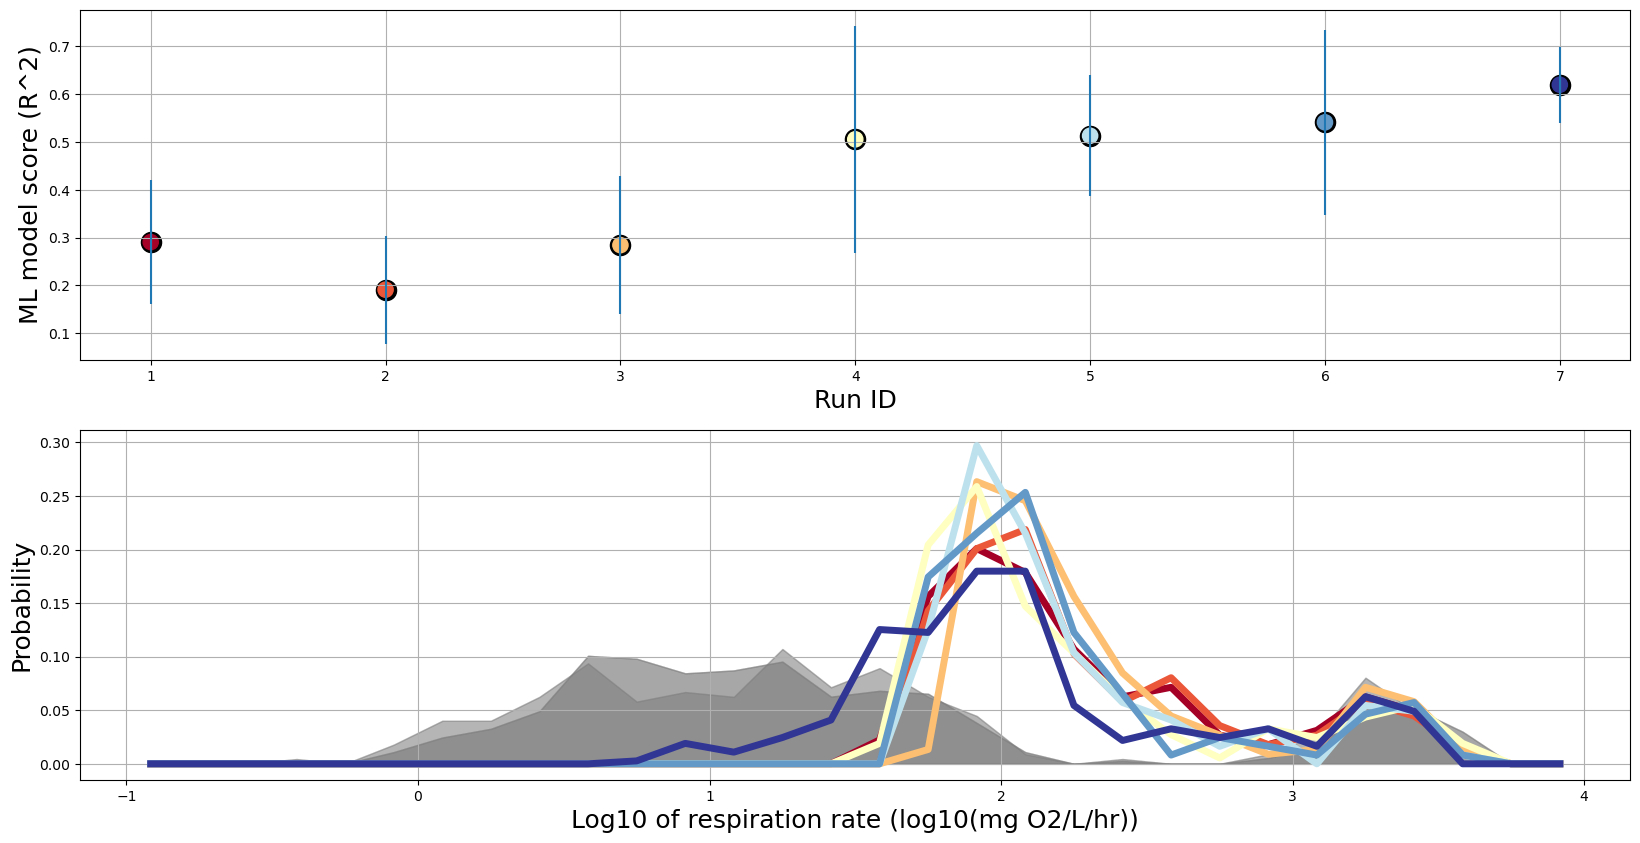

In [3]:
# Set up side-by-side plot
fig, (ax0, ax1)  = plt.subplots(2,1,figsize=(20,10))

# Plot progression of model score with training attempt
ax0.errorbar(model_scores.index+1, model_scores['hold-out-avg'],yerr=model_scores['hold-out-std'], fmt="none")
ax0.scatter(model_scores.index+1, model_scores['hold-out-avg'],s=210,c='black')
ax0.scatter(model_scores.index+1, model_scores['hold-out-avg'],s=120,c=cmap((np.array(branch_color, dtype='float32') - 1)/(len(list_branches) - 1)))
ax0.grid()
ax0.set_xlabel('Run ID', fontsize=18)
ax0.set_ylabel('ML model score (R^2)', fontsize=18)

# Plot progression of histograms (for bias) with training attempt
nbin = 30
min_bin = -1.0
max_bin = 4.0
for bb,branch in enumerate(list_branches):
    
    #======================================================
    # Histogram for training set truth reference
    #======================================================
    counts, bins = np.histogram(np.log10(np.abs(
        train_hist_df_list[list_branches.index(branch)][
            'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])), bins=nbin, range=(min_bin,max_bin))
    
    # Find the center of each bin
    # Divide number of counts in each bin by total number of counts => probability
    ax1.fill_between((bins[:-1]+bins[1:])/2,0,counts/np.sum(counts), color=('gray'), alpha=0.25)
    
    # This creates a plot with the same shape, but it's not clear to me what
    # exactly is being plotted - normalized counts maybe? Matplotlib docs do
    # not specify, so use more direct approach, above.
    #n, bins, patches = ax1.hist(
    #        np.log10(np.abs(train_hist_df_list[list_branches.index(branch)]['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    #        nbin, density=True, histtype="stepfilled", linestyle=('dashed'), color=('gray'), alpha=0.5)
    
    #======================================================
    # Histogram for predictions
    #======================================================
    
    # There are two options - predict_avg_ or predict_all_. The _all_ variants are much 
    # smoother and more spread out - they corrrespond to all the values predicted by
    # the SuperLearners, not averaged together into a single value. So there are 10x more
    # data points. The _avg_ variants are much rougher - they correspond to the average 
    # values predicted by the ensemble of SuperLearners - a smaller number of data points 
    # and also more concentrated histogram.
    counts, bins = np.histogram(np.log10(np.abs(
        predict_avg_hist_df_list[list_branches.index(branch)][
            'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])), bins=nbin, range=(min_bin,max_bin))
    
    # Find the center of each bin
    # Divide number of counts in each bin by total number of counts => probability
    ax1.plot(
        (bins[:-1]+bins[1:])/2,
        counts/np.sum(counts),
        linestyle=('solid'), color=cmap(((bb+1) - 1)/(len(list_branches) - 1)), linewidth=5, alpha=1.0)    
    
    # These histograms are much rougher - they correspond to the average values predicted by the
    # ensemble of SuperLearners - a smaller number of data points and also more concentrated
    # histogram.
    #n, bins, patches = ax1.hist(
    #        np.log10(np.abs(predict_avg_hist_df_list[list_branches.index(branch)]['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'].dropna())),
    #        nbin, density=True, histtype="step", linestyle=('solid'), color=cmap(((bb+1) - 1)/(len(list_branches) - 1)), linewidth=5, alpha=1.0)
    
    # These histograms are much smoother and more spread out - they corrrespond to all the values predicted by
    # the SuperLearners, not averaged together into a single value. So there are 10x more
    # data points. Since both histograms overlap pretty well, use these instead?
    #n, bins, patches = ax1.hist(
    #        np.log10(np.abs(predict_all_hist_df_list[list_branches.index(branch)]['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'].dropna())),
    #        nbin, density=True, histtype="step", linestyle=('solid'), color=cmap(((bb+1) - 1)/(len(list_branches) - 1)), linewidth=5, alpha=1.0)
    
ax1.grid()
ax1.set_ylabel('Probability', fontsize=18)
ax1.set_xlabel('Log10 of respiration rate (log10(mg O2/L/hr))', fontsize=18)

plt.savefig('fig05-ML-summary.pdf')

## Tabulate FPI results

Given a repository and branch name, this notebook will tabulate the FPI results into a ranked list of the most important features, concatenate feature descriptions and data sources, and then save the result as a CSV file for uploading into a document for publication format.

In [4]:
# Selet one branch on the repo
table_branch_name = 'Summer-2019-log10-r08'
#table_branch_name = 'S19S-SSS-log10-r02'

# Load data
! cd {repo_prefix}/{repo_name}; git checkout {table_branch_name}
fpi_avg = load_and_filter_fpi(repo_prefix+repo_name+'/output_data/fpi_avg.csv')
fpi_std = load_and_filter_fpi(repo_prefix+repo_name+'/output_data/fpi_std.csv')

Checking out files: 100% (335/335), done.
Switched to branch 'Summer-2019-log10-r08'


### Load context dictionaries

Here we create some dictorionaries defining the variables. The variable descriptions are based on the `./WHONDRS_v3_CM_SSS_dd.csv` data dictionary (copied from the [source repository](https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1923689)) and an manually transcribed data dictionary `./RiverAtlas_dd.csv` based on the [RiverAtlas data catalog](https://data.hydrosheds.org/file/technical-documentation/RiverATLAS_Catalog_v10.pdf) for RiverAtlas features.

Any feature not in these two data dictionaries will be classified as derived.

In [5]:
WHONDRS_features = pd.read_csv('WHONDRS_v3_CM_SSS_dd.csv',index_col=0)
RiverAtlas_features = pd.read_csv('RiverAtlas_dd.csv',index_col=0)

### Consolidate tables



In [6]:
# Initialize an empty dataframe to store the output table
FPI_summary = pd.DataFrame(columns=['ID','Importance','std(importance)','Source','Unit','Definition'],index=fpi_avg.index)

# Compute the mean, std, of the feature importance:
# Get summary statistics over each FPI (random shuffle
# of grouped features) iteration
mean = fpi_avg.mean(axis=1)
std = fpi_avg.std(axis=1)
uncert = fpi_std.max(axis=1)

# Loop over all features and gather information from data dictionaries
for feature in fpi_avg.index:
    
    # These values are set regardless of the data dictionary
    FPI_summary.loc[feature,'ID'] = feature_id_name_dict[feature]
    FPI_summary.loc[feature,'Importance'] = mean[feature]
    # This is the inter-run variance (among the ensembles of SuperLeaners)
    FPI_summary.loc[feature,'std(importance)'] = std[feature]
    # This is the intra-run variance (the max uncertainty over all individual SuperLearners)
    #FPI_summary.loc[feature,'Uncertainty in importance'] = uncert[feature]
    
    # Assign features based on data dictionary.  Need to relax the assignment
    # to allow for removing all _. and numbers from the variable names due to
    # slight inconsistencies with variable names here and in data dictionaries.
    if feature in WHONDRS_features.index:
        # Assign feature information from this data dictionary
        FPI_summary.loc[feature, 'Source'] = 'WH'
        FPI_summary.loc[feature, 'Unit'] = WHONDRS_features.loc[feature,'Unit']
        FPI_summary.loc[feature, 'Definition'] = WHONDRS_features.loc[feature,'Definition']
        
    elif feature in RiverAtlas_features.index:
        # Look in RiverAtlas
        FPI_summary.loc[feature, 'Source'] = 'RA'
        FPI_summary.loc[feature, 'Unit'] = RiverAtlas_features.loc[feature,'Unit']
        FPI_summary.loc[feature, 'Definition'] = RiverAtlas_features.loc[feature,'Definition']
        
    else:
        # Insert defaults
        print('WARNING! Feature '+feature+' not found in data dictionaries! Fill values inserted.')
        FPI_summary.loc[feature, 'Source'] = 'Derived'
        FPI_summary.loc[feature, 'Units'] = 'UNKNOWN'
        FPI_summary.loc[feature, 'Definition'] = 'UNKNOWN'
        
FPI_summary.sort_values(by='ID',ascending=True).to_csv('table01_'+table_branch_name+'.csv')

## Insert FPI summary table into manuscript

We are writing in LaTex, so a minor reformatting is required to copy and paste the table into the manuscript:
```
awk -v OFMT="%.2f" -v OFS=" & " -F, 'NR > 1 {print $2,$1,$3+0,$4+0,$5,$6,$7}' table01_Summer-2019-log10-r08.csv | tr '\n' '|' | sed 's/|/\\\\\n\\hline\n/g' | sed 's/_/ \\_/g' 
```
The above is complicated. It works in the following way:
1. Put the `ID` in the first column
2. `OFMT` specifies no more than 2 decimal places (convert values to numbers with `+0`)
3. `OFS` sets the output field separator to `&` for LaTeX tables
4. `NR > 1` skips over the `.csv` header since that is specified separately in the longtable.
5. `tr` replaces all newlines with `|` which are not present in the original file (it remains a unique marker of the presence of a newline)
6. Use `sed` to convert all `|` to LaTex table row terminations `\\` and horizontal line `\hline` with appropriate newline. Note that many `\` are needed to escape special characters so they are directly printed to the output, not interpreted with special meanings.
7. Put `\ ` (slash and space!) in front of all `_` in names - LaTex will enter Math mode otherwise! And, we want the space to allow for multi-line printing of long variable names in the table.

## Plot targets versus predictions for 2 branches (log10, nolog)

Checking out files: 100% (316/316), done.
Switched to branch 'S19S-SSS-log10-extrap-r01'
Checking out files: 100% (253/253), done.
Switched to branch 'S19S-SSS-nolog-extrap-r01'
Working on branch: S19S-SSS-log10-extrap-r01
Percent of false strong predictions for weak observations: 2.287581699346405
Percent of false weak predictions for strong observations: 14.754098360655737
Overall percent misclassified: 4.359673024523161
Working on branch: S19S-SSS-nolog-extrap-r01
Percent of false strong predictions for weak observations: 4.248366013071895
Percent of false weak predictions for strong observations: 9.836065573770492
Overall percent misclassified: 5.177111716621253


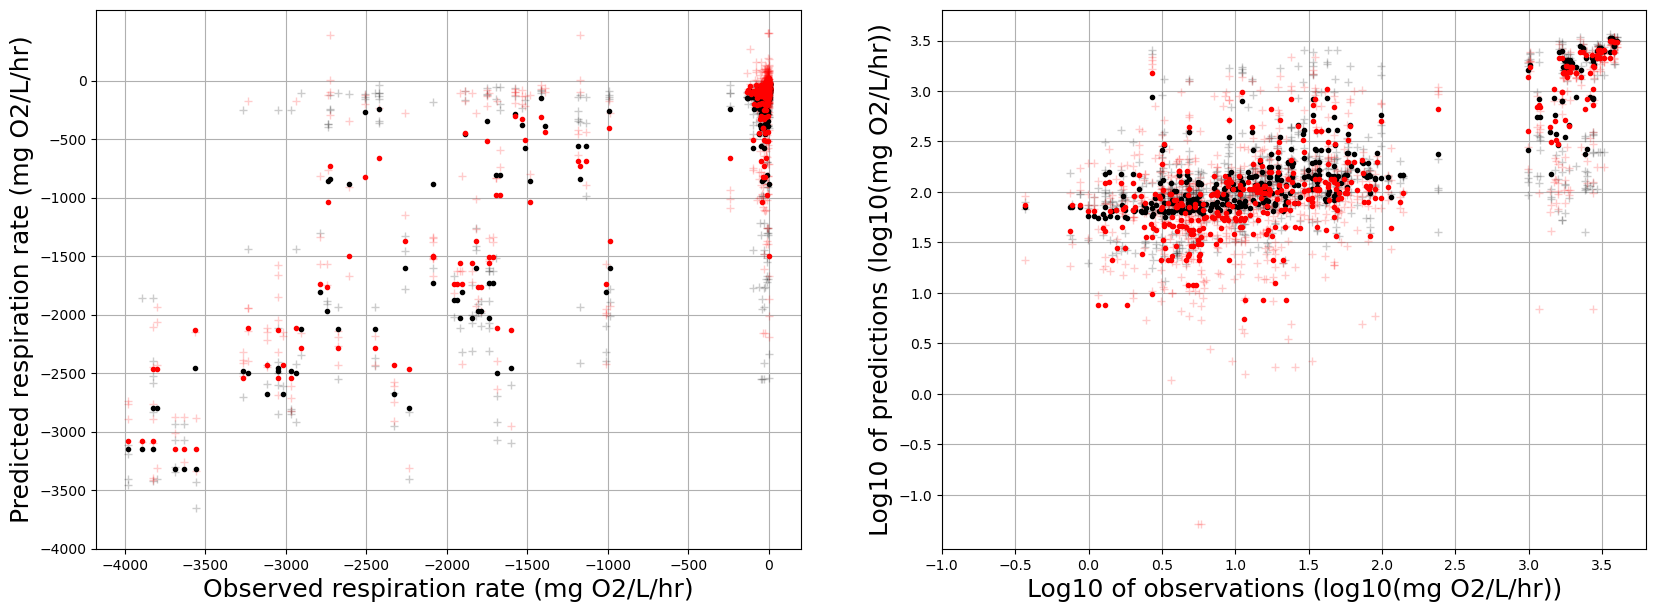

In [7]:
# Choose which branches to plot
branch1 = 'S19S-SSS-log10-extrap-r01'
branch2 = 'S19S-SSS-nolog-extrap-r01'

# Set up plot axes
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(20,7))

# Plot 1:1 lines underneath everything
# Comment out since grid is more informative.
#ax1.plot([-4000,-4000],[500,500],'k') #,color='gray', linewidth=2, linestyle='dashed')
#ax2.plot([0,0],[4,4],'k') #,color='gray', linewidth=2, linestyle='dashed')

#======================================================================
# Gather data from first branch and plot results from each SuperLearner
#======================================================================
! cd {repo_prefix}/{repo_name}; git checkout {branch1}

# Plot scatter from all predictions from individual SuperLearners
for ll in range(0,num_sl):
    b1_scatter = pd.read_csv(repo_prefix+repo_name+'/ml_models/sl_'+str(int(ll))+'/sl_scatter_test.csv')

    ax1.plot(
        b1_scatter['target'],
        b1_scatter['predicted'],
        'k+',alpha=0.2)
    ax2.plot(
        np.log10(np.abs(b1_scatter['target'])),
        np.log10(np.abs(b1_scatter['predicted'])),
        'k+',alpha=0.2)

#======================================================================
# Gather data from second branch and plot
#======================================================================
! cd {repo_prefix}/{repo_name}; git checkout {branch2}

for ll in range(0,num_sl):
    b2_scatter = pd.read_csv(repo_prefix+repo_name+'/ml_models/sl_'+str(int(ll))+'/sl_scatter_test.csv')

    ax1.plot(
        b2_scatter['target'],
        b2_scatter['predicted'],
        'r+',alpha=0.2)
    ax2.plot(
        np.log10(np.abs(b2_scatter['target'])),
        np.log10(np.abs(b2_scatter['predicted'])),
        'r+',alpha=0.2)
    
#=======================================================================
# We already have the overall average values, so plot those now so they
# appear on top of the individual SL predictions
#=======================================================================

# Loop over the two branches
dot_color=['k','r']

for ll, bb in enumerate([branch1, branch2]):
    
    print("Working on branch: "+bb)
    
    # Plot scatter from observed values and average predictions over all 
    # SuperLearners in ensemble on this branch. Merge the predict_avg_
    # data frame with the train_ data frame using the site ID as the
    # reference index.
    merged_scatter = predict_avg_hist_df_list[list_branches.index(bb)].join(
        train_hist_df_list[list_branches.index(bb)].set_index('Sample_ID'),
        how="left",
        lsuffix="_predict",
        rsuffix="_observe")

    ax1.plot(
        merged_scatter["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_observe"],
        merged_scatter["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_predict"],
        dot_color[ll]+'.')

    ax2.plot(
        np.log10(np.abs(merged_scatter["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_observe"])),
        np.log10(np.abs(merged_scatter["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_predict"])),
        dot_color[ll]+'.')
    
    # Count the number of misclassified points
    weak_obs = np.squeeze(
        merged_scatter[
            merged_scatter["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_observe"] >= -500.0])
    strong_obs = np.squeeze(
        merged_scatter[
            merged_scatter["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_observe"] < -500.0])
    
    # Find the number of false strong in weak data:
    total_weak = np.shape(weak_obs)[0]
    total_strong = np.shape(strong_obs)[0]
    
    false_strong_in_weak = np.shape(
        weak_obs[
              weak_obs["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_predict"] < -500])[0]
    
    false_weak_in_strong = np.shape(
        strong_obs[
              strong_obs["Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_predict"] >= -500])[0]
        
    print('Percent of false strong predictions for weak observations: '+
      str(100.0*false_strong_in_weak/total_weak))
    
    # Find the percentage of false weak in strong data:
    print('Percent of false weak predictions for strong observations: '+
      str(100.0*false_weak_in_strong/total_strong))
    
    print('Overall percent misclassified: '+
      str(100.0*(false_strong_in_weak+false_weak_in_strong)/(total_weak+total_strong)))
    

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-4000, 500, 500)
ax1.set_xticks(major_ticks)
ax1.set_yticks(major_ticks)
ax1.grid()

ax1.set_ylabel('Predicted respiration rate (mg O2/L/hr)', fontsize=18)
ax1.set_xlabel('Observed respiration rate (mg O2/L/hr)', fontsize=18)

major_ticks = np.arange(-1, 4, 0.5)
ax2.set_xticks(major_ticks)
ax2.set_yticks(major_ticks)
ax2.grid()

ax2.set_ylabel('Log10 of predictions (log10(mg O2/L/hr))', fontsize=18)
ax2.set_xlabel('Log10 of observations (log10(mg O2/L/hr))', fontsize=18)

# Write plot to file
plt.savefig('fig04-ML-scatter.pdf')